In [7]:
#Imports
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
import shutil
import gensim
import re
import string

import warnings 
warnings.filterwarnings(action = 'ignore')
# nltk.download('stopwords')

# Load Data

In [8]:
#Read our csv
data = pd.read_csv("train.csv", on_bad_lines='skip')

data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
data.shape

(404290, 6)

# Drop null values

In [10]:
data = data.dropna().reset_index(drop=True)

In [11]:
data.shape

(404287, 6)

# Taking sample from data since the data is very large

In [12]:
new_df = data.sample(30000, random_state=2)
new_df.shape

(30000, 6)

# Preprocessing

In [13]:
def preprocessing(q):
    
    #Replacing symbols in  our data
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')    
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    
    import contractions
    
    contractedQuestions= []
    #Removing any Contractions From Questions
    for word in q.split():
        contractedQuestions.append(contractions.fix(word))
        
    #Merge our question back together 
    q = ' '.join(contractedQuestions)
    
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    
    #Removing HTML Tags
    q = BeautifulSoup(q)
    q = q.get_text()

    #Removing Punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    #Removing Numbers From Data
    num = re.compile('\d+')
    q = re.sub(num,"num",q) 
    
    
    return q

In [14]:
#Apply preprocessing on our set of questions
new_df['question1'] = new_df['question1'].apply(preprocessing)
new_df['question2'] = new_df['question2'].apply(preprocessing)

# Convert all questions to lowercase letters 

In [15]:
new_df['question1']= new_df['question1'].str.lower()
new_df['question2']= new_df['question2'].str.lower()

# Remove Stop Words

In [16]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
new_df["question1"] = new_df["question1"] .apply(lambda x: ' '.join(word for word in str(x).split() if word.casefold()not in (stop_words)))
new_df["question2"] = new_df["question2"] .apply(lambda x: ' '.join(word for word in str(x).split() if word.casefold()not in (stop_words)))

# Words Lemmatizing

In [17]:
from nltk.stem import WordNetLemmatizer
import nltk

lemmatizer = WordNetLemmatizer()
new_df["q1_lemma"] = new_df["question1"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))
new_df["q2_lemma"] = new_df["question2"].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))

In [18]:
# we don't need the original questions anymore
new_df.drop(['question1','question2'], axis=1,inplace = True)

In [19]:
new_df.head()

,id,qid1,qid2,is_duplicate,q1_lemma,q2_lemma
331533,331535,169053,295926,1,learn norwegian,quickest way learn norwegian
45407,45407,81383,81384,1,currency rate determined,exchange rate determined
286198,286200,285024,406729,0,substitution,substitute caciocavallo
157194,157195,245856,245857,1,make iphone nums faster io num num,iphone nums make faster comfortable use
154345,154346,242075,242076,1,help girlfriend cope parent divorce,help girlfriend parent divorce


# Feature Extraction

In [20]:
#Questions length
new_df['q1_len'] = new_df['q1_lemma'].apply(lambda row: len(str(row).split(" ")))
new_df['q2_len'] = new_df['q2_lemma'].apply(lambda row: len(str(row).split(" ")))

In [21]:
#Common words between questions
new_df['common_words'] = new_df.apply(lambda r: set(str(r['q1_lemma']).split()) & set(str(r['q2_lemma']).split()),axis=1)
new_df['common_count'] = new_df['common_words'].str.len()

In [22]:
#Total words of both questions
total_words = new_df['q1_len'] + new_df['q2_len']
new_df['total_words']= total_words

In [23]:
#Common words shared between them ratio
new_df['word_share_ratio'] = round(new_df['common_count']/new_df['total_words'],2)

In [24]:
# Tokenizing sentences
from nltk.tokenize import word_tokenize
new_df['q1_lemma'] = new_df.apply(lambda row: nltk.word_tokenize(row["q1_lemma"]), axis=1)
new_df['q2_lemma'] = new_df.apply(lambda row: nltk.word_tokenize(row["q2_lemma"]), axis=1)

In [25]:
final_df = new_df.drop(columns=['id','qid1','qid2','q1_lemma','q2_lemma','common_words'])
final_df.head()

,is_duplicate,q1_len,q2_len,common_count,total_words,word_share_ratio
331533,1,2,4,2,6,0.33
45407,1,3,3,2,6,0.33
286198,0,1,2,0,3,0.00
157194,1,7,6,4,13,0.31
154345,1,5,4,4,9,0.44


# Data Satistics Visualization

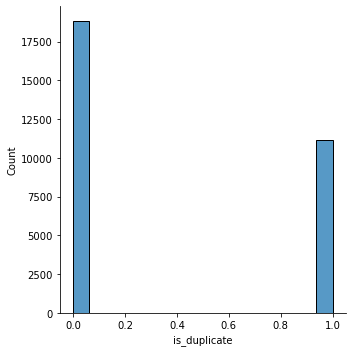

In [26]:
sns.displot(final_df['is_duplicate'])

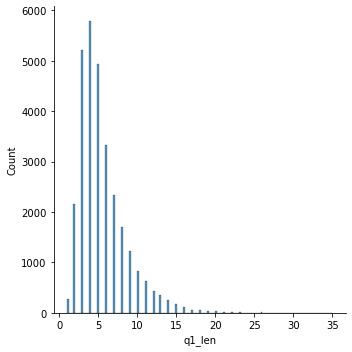

In [27]:
sns.displot(final_df['q1_len'])

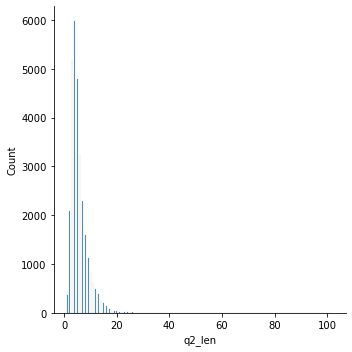

In [28]:
sns.displot(final_df['q2_len'])

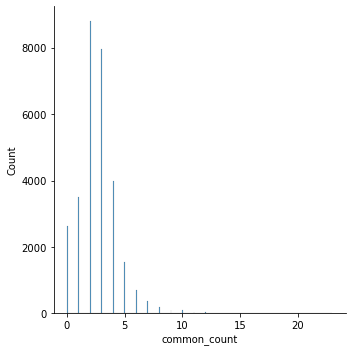

In [29]:
sns.displot(final_df['common_count'])

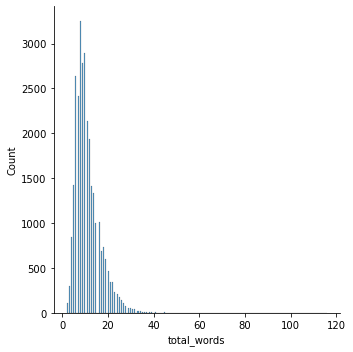

In [30]:
sns.displot(final_df['total_words'])

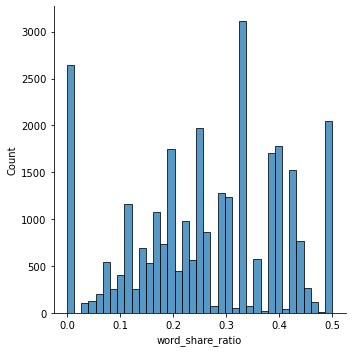

In [31]:
sns.displot(final_df['word_share_ratio'])

# Word2Vec Model

In [32]:
#Preparing a list of tokenized sentences to give to the word2Vec model 
Sentences1 = []
for row in new_df["q1_lemma"]:
    temp=[]
    for i in row:
        temp.append(i)
    Sentences1.append(temp)

In [33]:
Sentences2 = []
for row in new_df["q2_lemma"]:
    temp=[]
    for i in row:
        temp.append(i)
    Sentences2.append(temp)

In [34]:
#Final list that will be inserted into Word2Vec
Sentences = Sentences1 + Sentences2

# Model Training

In [36]:
model = gensim.models.Word2Vec(Sentences,min_count=10,
                     window=3,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,workers=4)

In [37]:
model.train(Sentences, total_examples = model.corpus_count, epochs=30, report_delay=1)

(4477938, 10091790)

In [38]:
#Get cosine similarity between a word and words most similar to it
#model.wv.most_similar(positive=['child'])

# Creating word Vectors as Features 

In [39]:
#Average vectors of question 1
q1_avg_vectors =[]
for q in Sentences1:
    vector = np.zeros(300)
    num_of_words = 0
    for word in q:
        try:
            vector = vector + model.wv[word]
            num_of_words = num_of_words + 1
        except:
            pass
    q1_avg_vectors.append(vector/num_of_words)    

In [40]:
#Average vectors of question 2
q2_avg_vectors =[]
for q in Sentences2:
    vector = np.zeros(300)
    num_of_words = 0
    for word in q:
        try:
            vector = vector + model.wv[word]
            num_of_words = num_of_words + 1
        except:
            pass
    q2_avg_vectors.append(vector/num_of_words)  

In [41]:
#Convert them into arrays
q1_vec = np.array(q1_avg_vectors)
q2_vec = np.array(q2_avg_vectors)

In [42]:
q1_vec.shape, q2_vec.shape

((30000, 300), (30000, 300))

In [43]:
#Store them into a dataframe
temp_df1 = pd.DataFrame(q1_vec)
temp_df2 = pd.DataFrame(q2_vec)
temp_df = pd.concat([temp_df1, temp_df2], axis=1, ignore_index=True)

In [44]:
#Concatenate to our final dataframe
final_df = pd.concat([temp_df, final_df], axis=1)
#Fill null values with zero
final_df = final_df.fillna(0)
final_df

,0,1,2,3,4,5,6,7,8,9,...,596,597,598,599,is_duplicate,q1_len,q2_len,common_count,total_words,word_share_ratio
0,-0.248331,0.135727,0.105354,0.369843,0.130486,-0.188654,0.210214,0.200737,0.012613,0.005895,...,0.101131,-0.012394,-0.066576,0.232293,0.0,0.0,0.0,0.0,0.0,0.00
1,0.311464,0.236277,-0.117879,0.309556,-0.157217,-0.251982,0.406611,-0.250046,-0.010143,0.096408,...,-0.096731,-0.005767,0.158889,0.099329,0.0,0.0,0.0,0.0,0.0,0.00
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.120333,-0.354561,0.168226,-0.358042,0.0,0.0,0.0,0.0,0.0,0.00
3,-0.145936,0.104591,0.091186,0.416200,0.239939,0.030382,0.051501,0.223844,0.122580,0.046928,...,0.031596,0.083293,-0.143109,0.097868,0.0,3.0,9.0,0.0,12.0,0.00
4,0.042061,0.151736,-0.002000,0.105814,0.047360,-0.302294,-0.034627,0.208969,0.034915,0.071678,...,0.061885,-0.201989,0.007919,0.005647,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,3.0,4.0,1.0,7.0,0.14
125044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,4.0,3.0,3.0,7.0,0.43
313993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,5.0,17.0,3.0,22.0,0.14
203569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,3.0,4.0,2.0,7.0,0.29


In [45]:
#Target
Y = final_df["is_duplicate"]
#Features
X = final_df.drop("is_duplicate", axis=1)

# Split our dataset into train & test

In [46]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,Y,test_size=0.2,random_state=1)

# Logistic Regression Model

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
modelLogistic = LogisticRegression()
modelLogistic.fit(Xtrain,ytrain)
y_pred = modelLogistic.predict(Xtest)
Accuracy_logistic =round(accuracy_score(ytest,y_pred), 2)
print("Accuracy of Logistic Regression: {}% ".format(Accuracy_logistic*100))

Accuracy of Logistic Regression: 83.0% 


# Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)
y_pred = rf.predict(Xtest)
Accuracy_random =round(accuracy_score(ytest,y_pred), 2)
print("Accuracy of Random Forest: {}% ".format(Accuracy_random*100))

Accuracy of Random Forest: 84.0% 


# Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
dTree_clf = DecisionTreeClassifier()
dTree_clf.fit(Xtrain,ytrain)
ypred2 = dTree_clf.predict(Xtest)
Accuracy_tree =round(accuracy_score(ytest,ypred2), 2)
print("Accuracy of Decision Tree: {}% ".format(Accuracy_tree*100))

Accuracy of Decision Tree: 84.0% 


# Model Visualization

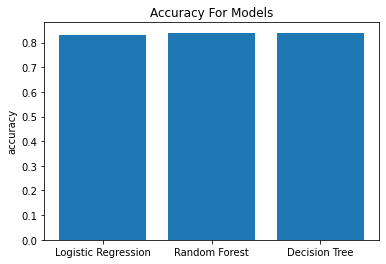

In [50]:
# bar graph for Accuracy
Plotdaata=['Logistic Regression','Random Forest','Decision Tree']
plotnum = [Accuracy_logistic, Accuracy_random,Accuracy_tree]
plt.bar(Plotdaata, plotnum)
plt.title("Accuracy For Models")
plt.ylabel("accuracy")
plt.show()